## <u>Time Series Analysis - A Practical Approach</u>
    Time series data are sets of observations collected for a particular individual or entity over different points in time.
    Time series data focus on the same variable over a period, whereas cross-sectional data focus on several variables at a single point in time.
    For example: X(t), X(t+1), X(t+2), ..., X(t+n) represents a time series corresponding to the values of a variable X over the period t, t+1, ..., t+n.

    The goal of time series analysis is to understand the underlying stochastic mechanism and forecast future values of the series based on its historical behavior.

**Why Time Series?**

- Understand underlying trends and patterns
- Predict the likelihood of future events
- Make inferences about the probability model governing the series
- Develop confidence intervals and perform hypothesis tests on model parameters

---

## Data Loading and Preprocessing

### Data Loading

In [1]:
import pandas as pd 
import numpy as np

data = pd.read_csv('Index2018.csv')
df_comp = data.copy()
# df_comp

#### Setting Date column to Datetime format and making it the index

In [2]:
df_comp.date = pd.to_datetime(df_comp.date,dayfirst=True)
df_comp.set_index('date', inplace=True)

#### Setting the frequency of the data
Sets the frequency of the time series index to business days ('b'). \
Ensures the index has a row for every weekday (Mon–Fri).
Inserts missing dates if some business days are absent from the dataset (e.g. holidays, weekends).


In [3]:
df_comp = df_comp.asfreq('b')

####  Filling missing values
Fills in missing values using the forward fill method which copies the last known value forward to fill gaps.

In [4]:

df_comp = df_comp.fillna(method='ffill')

C:\Users\abhij\AppData\Local\Temp\ipykernel_26048\998377250.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_comp = df_comp.fillna(method='ffill')


#### Keeping one index for the analysis and deleting the rest

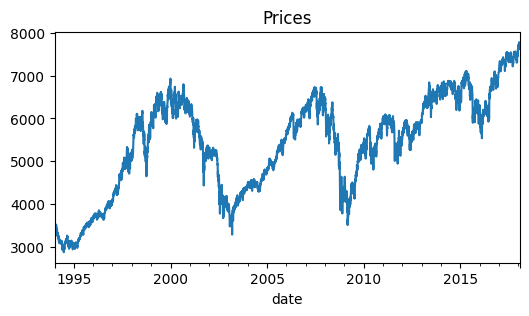

In [5]:
df_comp['market_value'] = df_comp.ftse 

df_for_later_analysis = df_comp.copy()

del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']

import matplotlib.pyplot as plt

df_comp.market_value.plot(figsize=(6,3),title = "Prices")
plt.show()


#### Splitting the test and train data (80:20)

In [6]:
size = int(len(df_comp) * 0.8)
df, df_test = df_comp[:size], df_comp[size:]

---

## Time Series Decomposition 
    Time series decomposition is the process of breaking a complex temporal signal into interpretable parts
Any time series can be decomposed into the following four components
* **Trend (T):** Long-term movement or direction in the data (increasing, decreasing, flat)
* **Seasonality (S):** Regular, repeating patterns at fixed intervals (< 1 year ⇒ (daily, weekly, yearly), eg: Temperature data) 
* **Cyclicity (C):** Gradual and relatively long term up and down movement of a series (> 2 years, eg: business performanec of a company)
* **Residual (I):** Irregular “noise” left after removing trend and seasonality.

#### Additive Decomposition
If the time series Y(t) can be expressed as the sum of all components of a time series then its called an additive time series. \
⇒  **Y(t) = T(t) + S(t) + C(t) + I(t)**
#### Multiplicative Decomposition
If the time series Y(t) can be expressed as the product of all components of a time series then its called a multiplicative time series. \
⇒  **Y(t) = T(t) * S(t) * C(t) * I(t)**
#### When to use additive and multiplicative decomposition?
If the seasonal spread (distance between peaks/troughs) is constant over time then its an additive series and \
If the seasonal spread (distance between peaks/troughs) is varying over time then its a multiplicative series.

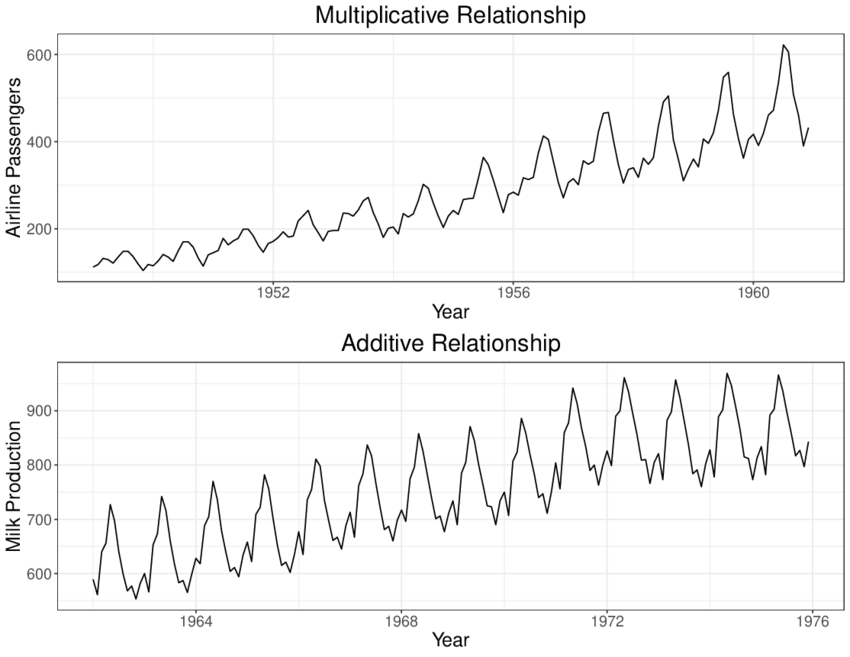

#### Types of Decomposition
Classical and STL decomposition are two important techniques in time series analysis used to break a time series into its fundamental components: trend, seasonality, and residual

#### 1. Classical Decomposition 
Classical decomposition is a traditional technique that assumes a fixed model form (additive or multiplicative) to separate components.

**Steps:**
- Estimate the trend – using a moving average (e.g., centered moving average).
- Detrend the series – subtract the trend (additive) or divide (multiplicative).
- Estimate seasonality – by averaging detrended values for each season.
- Remove trend and seasonality to get residuals.

**Advantages:**
- Can handle both additive and multiplicative models.

**Limitations:**
- Assumes constant seasonality.
- Not very robust to outliers or non-linear trends.


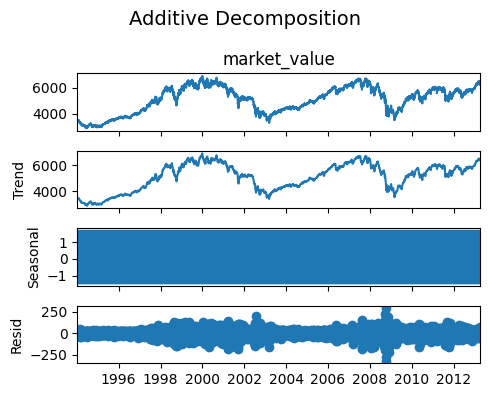

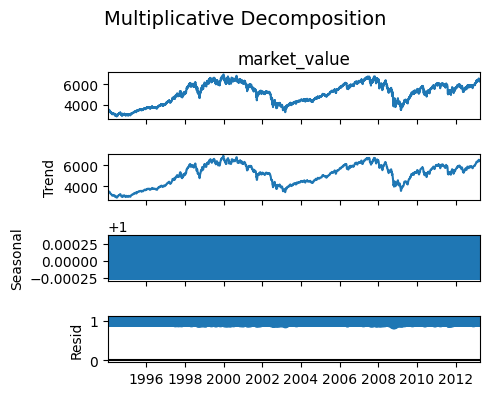

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

sesaonal_decompose_additive = seasonal_decompose(df.market_value, model='additive')
sesaonal_decompose_multiplicative = seasonal_decompose(df.market_value, model='multiplicative')

## Classical Decomposed Components
# trend_classical = sesaonal_decompose_additive.trend
# seasonal_classical = sesaonal_decompose_additive.seasonal
# resid_classical = sesaonal_decompose_additive.resid

fig1 = sesaonal_decompose_additive.plot()
fig1.set_size_inches(5, 4)
fig1.suptitle('Additive Decomposition', fontsize=14)
fig1.tight_layout()

fig2 = sesaonal_decompose_multiplicative.plot()
fig2.set_size_inches(5, 4)
fig2.suptitle('Multiplicative Decomposition', fontsize=14)
fig2.tight_layout()

plt.show()

#### 2. STL Decomposition / Seasonal Trend Decomposition using LOESS
Its a decomposition technique which uses LOESS (Locally Estimated Scatterplot Smoothing) for smoothing both the trend and seasonal components. It shows the actual seasonal pattern.

**Advantages**
- It can handle any type of seasonality (weekly, monthly, quarterly, etc.) and seasonality that changes over time
- It handles missing values or outliers better than classical methods.

**Limitations**
- It can handle only additive models or cannot handle multiplicative models

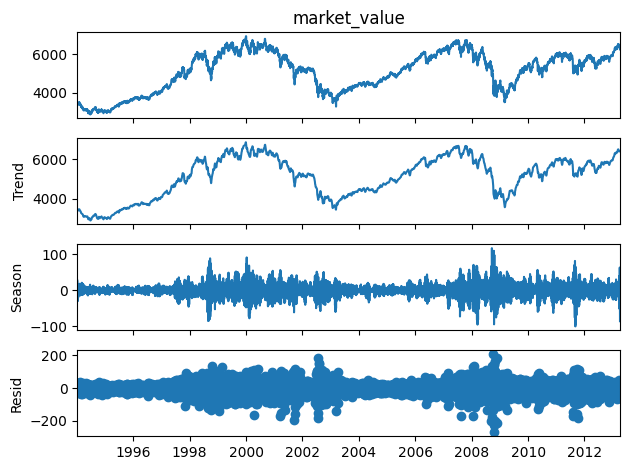

In [8]:
from statsmodels.tsa.seasonal import STL
stl_decomp = STL(df['market_value'])
result = stl_decomp.fit()
result.plot()
plt.show()

Here we can see that STL decomposition is giving a better picture about the seasonal component or seasonal variation compared to the classical decomposition. \
So whenever we are having an additive model we uses STL decomposition and whenever we have a multiplicative model we use Classical decomposition.

---

## Time Series Smoothing
    Smoothing in time series is a fundamental technique used to reveal underlying trends and patterns by reducing noise or random variation. It's useful when we're trying to understand long-term movements in data, seasonal fluctuations, or detect shifts, cycles, or outliers.
    
    Smoothing is the process of replacing each data point with a value derived from its neighbors (or the series as a whole) to highlight structural patterns (trend, seasonality) and suppress short-term fluctuations**

#### Why is Smoothing Needed?
1. **Noise Reduction**: Removes randomness to make patterns clearer.
2. **Trend Estimation**: Helps isolate and visualize trends over time.
3. **Forecasting**: Many forecasting models use smoothed data as input.
4. **Anomaly Detection**: Makes it easier to spot deviations or outliers.
5. **Pre-processing**: Useful as a preprocessing step for machine learning and statistical models.

## Types of Smoothing Techniques
### 1. Simple Moving Average (SMA)
The Simple Moving Average (SMA) is the most basic type of smoothing technique in time series. It is used to reduce short-term fluctuations and highlight long-term trends or cycles in the data. 

It works by taking the arithmetic mean of a fixed number of past observations (called the "window" or "rolling window") and sliding it forward over time.

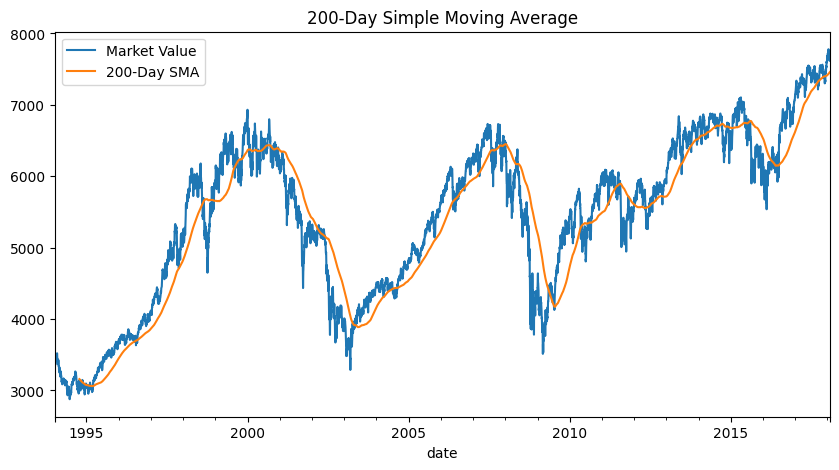

In [43]:
simple_moving_average = df_comp.market_value.rolling(window=200).mean()
df_comp.market_value.plot(figsize=(10,5), title='Actual Series')
simple_moving_average.plot(figsize=(10,5), title='200-Day Simple Moving Average')
plt.legend(['Market Value', '200-Day SMA'])
plt.show()

#### Properties of SMA
- **Fixed window size**:	We must choose a window (e.g., 3, 5, 7).
- **Lagging**:	SMA lags behind the actual data — trend detection is delayed.
- **Equal weight**:	All values in the window are equally important — can underreact to change.
- **No forecasting**:	Purely descriptive; not predictive on its own.

#### Limitations
- **Lag Effect**: Since it averages past values, it reacts slowly to recent changes.
- **Equal Weighting**: Doesn’t prioritize recent data (unlike Exponential Moving Average).
- **Data Loss at Start**: The first 𝑘−1 data points can’t have an SMA value.
- **Sensitive to Window Size**: Choosing a wrong window can mislead the analysis.

### 2. Weighted Moving Average (WMA)
The Weighted Moving Average (WMA) is a smoothing technique similar to the Simple Moving Average.

WMA assigns higher importance (weight) to recent observations and lower importance to older ones, instead of treating all values equally like SMA.

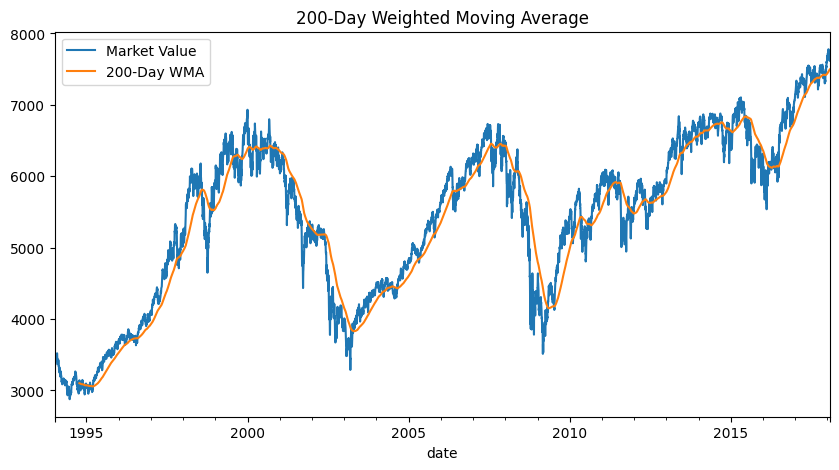

In [44]:
def weighted_moving_average(series, window):
    weights = np.arange(1, window + 1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

wma_200 = weighted_moving_average(df_comp.market_value, 200)
df_comp.market_value.plot(figsize=(10,5), title='Actual Series')
wma_200.plot(figsize=(10,5), title='200-Day Weighted Moving Average')
plt.legend(['Market Value', '200-Day WMA']) 
plt.show()

| Pros                         | Cons                                    |
| ---------------------------- | --------------------------------------- |
| Faster response to new data  | Slightly more complex than SMA          |
| Customizable weight logic    | Can overreact to noise in volatile data |
| Better for short-term trends | Might lag behind EMA in momentum shifts |


### 3. Exponential Smoothing
Exponential Smoothing is a powerful and flexible time series smoothing technique that uses exponentially decreasing weights for past observations — meaning more recent values have a greater influence on the forecast.

Unlike Simple Moving Average (SMA) or Weighted Moving Average (WMA), where weights are fixed or linearly defined, Exponential Smoothing assigns weights that decay exponentially as we move further back in time.

#### Types of Exponential Smoothing
There are majorly 3 types of exponential smoothing techniques.

- #### Simple Exponential Smoothing (SES)
    Used when the time series has no trend or seasonality (i.e., stationary).

    𝑆
    𝑡=
    𝛼
    𝑋
    𝑡
    +
    (
    1
    −
    𝛼
    )
    𝑆
    𝑡
    −
    1

    Where:

    𝑆
    𝑡
    ​
    = Smoothed value at time 
    𝑡

    𝑋
    𝑡
    ​
    = Actual value at time 
    𝑡

    𝛼
    ∈
    (
    0
    ,
    1
    )
    = Smoothing parameter (higher = more reactive)

    **Interpretation**: 

    Higher α (e.g., 0.9) → More weight on recent data → reacts quickly \
    Lower α (e.g., 0.1) → More smoothing, less sensitive to recent changes

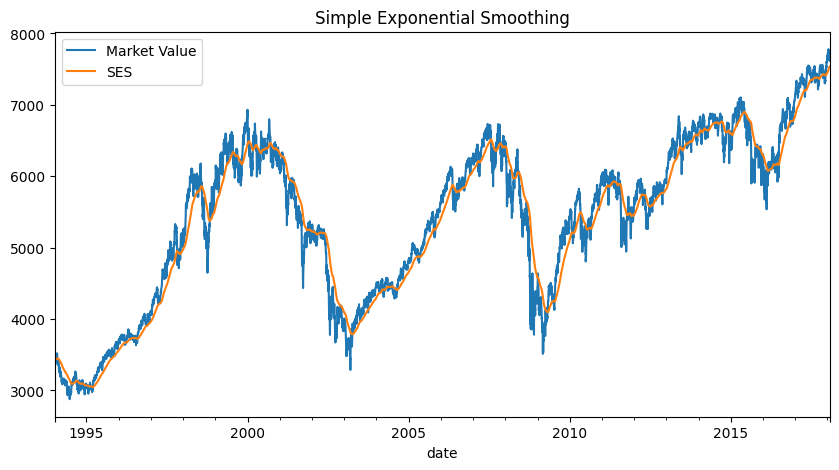

In [59]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(df_comp['market_value']).fit(smoothing_level=0.02, optimized=False)
df_ses = ses_model.fittedvalues
df_comp.market_value.plot(figsize=(10,5), title='Actual Series')
df_ses.plot(figsize=(10,5), title='Simple Exponential Smoothing')
plt.legend([ 'Market Value', 'SES'])
plt.show()

- #### Holt’s Linear Exponential Smoothing
    Used when the time series has trend but no seasonality.

    𝐿
    𝑡
    ​
    : level at time 
    𝑡

    𝑇
    𝑡
    ​
    : trend at time 
    𝑡

    𝐿
    𝑡=
    𝛼
    𝑋
    𝑡
    +
    (
    1
    −
    𝛼
    )
    (
    𝐿
    𝑡
    −
    1
    +
    𝑇
    𝑡
    −
    1
    )

    𝑇
    𝑡=
    𝛽
    (
    𝐿
    𝑡
    −
    𝐿
    𝑡
    −
    1
    )
    +
    (
    1
    −
    𝛽
    )
    𝑇
    𝑡
    −
    1

    Forecast =
    𝐿
    𝑡
    +
    ℎ
    ⋅
    𝑇
    𝑡
    
    Where:
    𝛼: smoothing for level
    𝛽: smoothing for trend
    ℎ: steps ahead forecast

C:\Users\abhij\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


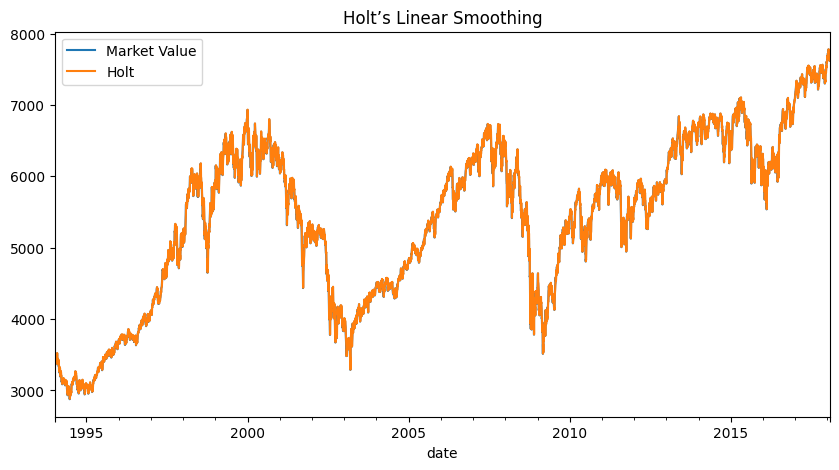

In [60]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_model = ExponentialSmoothing(df_comp['market_value'], trend='add', seasonal=None).fit()
df_holt = holt_model.fittedvalues
df_comp.market_value.plot(figsize=(10,5), title='Actual Series')    
df_holt.plot(figsize=(10,5), title='Holt’s Linear Smoothing')
plt.legend([ 'Market Value','Holt'])
plt.show()


- #### Holt-Winters Exponential Smoothing
    Use when the time series has both trend and seasonality.

    There are two types of HWES: 
    - **Additive**: constant seasonal variation 
    - **Multiplicative**: seasonal variation proportional to level

    **Equation(Additive form)**: \
    𝑆
    𝑡
    ​: smoothed value \
    𝑇
    𝑡
    ​: trend \
    𝐼
    𝑡
    ​: seasonal component \
    𝑚
    : season length (e.g., 12 for monthly)

    L 
    t
    =α(X 
    t
    ​
    −I 
    t−m
    ​
    )+(1−α)(L 
    t−1
    ​
    +T 
    t−1
    ​
    )
    ​
    
    T 
    t
    =β(L 
    t
    ​
    −L 
    t−1
    ​
    )+(1−β)T 
    t−1
    ​
    
    I 
    t
    =γ(X 
    t
    ​
    −L 
    t
    ​
    )+(1−γ)I 
    t−m
    ​
    
    Forecast 
    t+h
    =L 
    t
    ​
    +hT 
    t
    ​
    +I 
    t+h−m(k)

C:\Users\abhij\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


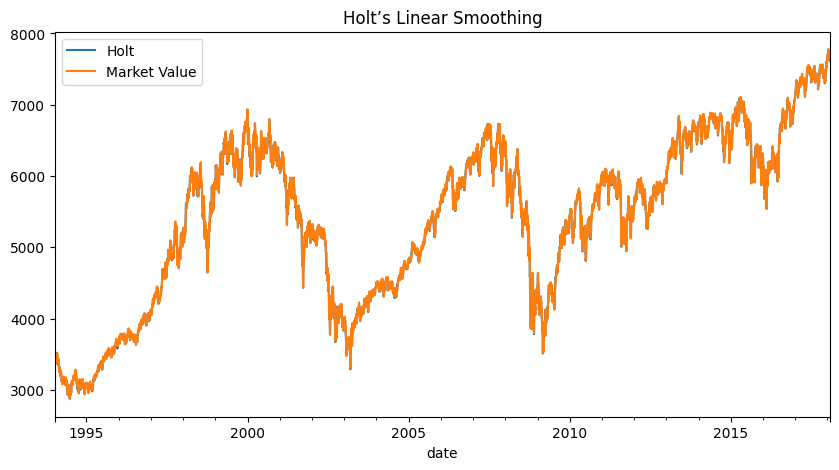

In [65]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_model = ExponentialSmoothing(df_comp['market_value'], trend='add', seasonal='add', seasonal_periods=12).fit()
df_holt = holt_model.fittedvalues
df_comp.market_value.plot(figsize=(10,5), title='Actual Series')    
df_holt.plot(figsize=(10,5), title='Holt’s Linear Smoothing')
plt.legend(['Holt', 'Market Value'])
plt.show()

#### When to use SES, Holt's Linear or Holt-Winter?
| Data Type               | Recommended Method           |
| ----------------------- | ---------------------------- |
| No trend or seasonality | Simple Exponential Smoothing |
| Trend only              | Holt’s Linear Smoothing      |
| Trend + seasonality     | Holt-Winters Smoothing       |


### When to Use Which?
- If you want simple, quick smoothing → Use SMA or SES
- If your data has trend → Use Holt’s
- If your data has trend + seasonality → Use Holt-Winters

---

## <u>Basic Time Series Models</u>

## 1. White Noise
    Its a Time Series with no pattern, trend or seasonality
**Characteristics:**
- Constant Mean / Zero Mean
- Constant Variance
- No Auto-correlation
- Independent ⇒ WN ~ iid(0,σ²)

In [10]:
# Our intention is to create a white noise series similar to the market value series and compare the two.
# We will generate a random white noise series using the same mean and standard deviation as the market value series.

mean = df.market_value.mean()
std = df.market_value.std()
wn = np.random.normal(loc= mean, scale= std, size= len(df))
df['White Noise'] = wn 
# df 

C:\Users\abhij\AppData\Local\Temp\ipykernel_26048\3763445999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['White Noise'] = wn


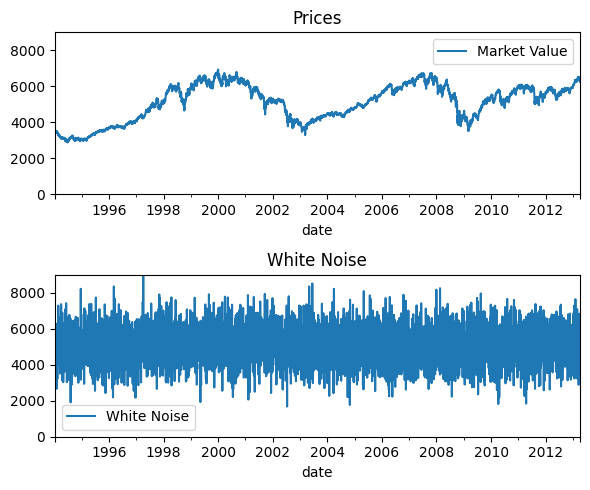

In [11]:
# Plotting the Market Value and White Noise series for comparison
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5))

# Plot Market Value
df['market_value'].plot(ax=axes[0], title="Prices")
axes[0].set_ylim([0, 9000]) # fixing the y-axis limit for better comparison
axes[0].legend(['Market Value'])

# Plot White Noise
df['White Noise'].plot(ax=axes[1], title="White Noise")
axes[1].set_ylim([0, 9000]) # fixing the y-axis limit for better comparison
axes[1].legend(['White Noise'])

plt.tight_layout()
plt.show()

Here you can see that the White Noise plot has \
Completely random data points with no correlation between the previous values ⇒ No Auto-Correlation,\
Having a constant spread ⇒ Constant Mean, \
And located around the mean value ⇒ Constant Mean. \
\
This is a classic zero-mean, constant variance, i.i.d. process. It's exactly what residuals should look like after fitting a good time series model. \
\
. 

## 2. Random Walk
    Its a cumulative time series where each value depends on the previous one plus some random error e ~ WN(0,σ²) and with no predictable pattern
**Characterisitcs**
* Non-Constant Mean
* Non-Constant Variance
* Autocorrelated 
* Non-Stationary
* Unpredictable trend 
* First order differencing can make the series stationary



C:\Users\abhij\AppData\Local\Temp\ipykernel_26048\516366205.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Random Walk'] = random_walk


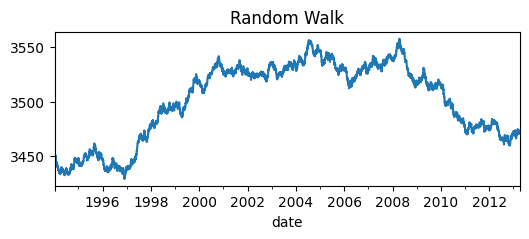

In [12]:
# Generating a Random Walk from the Market Value Series

np.random.seed(42)
# Parameters
n = len(df) 
start_value = df['market_value'].iloc[0]   # Starting value from the market value series

white_noise = np.random.normal(loc=0, scale=1, size=n)  # Generating a white noise

# Create a random walk by cumulatively summing the white noise and adding the starting value
random_walk = np.cumsum(white_noise) + start_value

df['Random Walk'] = random_walk
df['Random Walk'].plot(figsize=(6,2), title="Random Walk")
plt.show()

The graph shows a completely random series with no trend or any statistical properties, which is a realistic example of a random walk that is similar to the stock prices.


---

## Stationarity
    Its one of the most common assumptions in time series analysis. 
    When we say a time series is staionary if the distribution or the moments (mean & variance) doesnot change over time i.e. The process is in statistical equilibrium. 
    Strong Stationarity ⇒ Time Invariant

### Weak/Covariance Stationarity
A time series is said to be weak/covariance stationary if its first and second moment are unaffected by the change in time t. \

Weak Stationary process exhibits the following properties.
* Constant Mean
* Constant Variance
* Covariance & Correlation depends only on lag h and not on time t i.e. time invariant
* Joint pdf is time dependent

**Why do we need Stationarity?** \
Stationarity assumes certain statistical properties throughout the time and makes the prediction easier. And the forecasting model requires stationarity.

### Tests For Weak Stationarity

Before looking at the tests for stationarity lets look at its deciding factor Unit Root. 

**Unit Root:** It is a characteristic of a stochastic process that indicates non-stationarity and can lead to problems in statistical inference. The presence of unit root means that the shocks to the series can have permanent effects, rather than fading away over time. That is a time series with unit root doesnot revert to a mean & variance increases over time. First order differencing helps in removing unit root and makes the series stationary.

#### 1. Augmented Dickey-Fuller Test (ADF Test)
ADF test checks the presence of a unit root in the time series. Unit root is a sign that tells you whether a time series is stationary or not. \
**H0**: Non-Stationary (Data have a unit root) \
**H1**: Stationary (Data doesnot have a unit root) 

In other words or mathematically we can say that \
**H0**: 1-lag auto-correlation coefficient (φ) < 1 \
**H1**: 1-lag auto-correlation coefficient (φ) = 1 \

**Decision Criteria** \
If ADF Statistic < Critical Value, we reject H0 &nbsp; **OR** &nbsp;  If p value < α (0.05), we reject H0




In [13]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['market_value'])

(np.float64(-1.9041551418836848),
 np.float64(0.33010893277028397),
 6,
 5014,
 {'1%': np.float64(-3.4316548765428174),
  '5%': np.float64(-2.8621166146845334),
  '10%': np.float64(-2.5670769326348926)},
 np.float64(54854.15304507557))

### Interpretation of the Output

| Metric                     | Value       |
|---------------------------|-------------|
| Test Statistic/ ADF Statistic| -1.904      |
| p-value                   | 0.330       |
| # of Lags Used            | 6           |
| # of Observations         | 5014        |
| Critical Value @ 1%       | -3.431      |
| Critical Value @ 5%       | -2.862      |
| Critical Value @ 10%      | -2.567      |
| Maximized Info Criterion  | 54854.153   |


Since (ADF Statistic) −1.904 > −2.862 (Critical Values at 5%), \
& p-value 0.330 > 0.05, we **fail to reject the null hypothesis H0**.

⇒ **The time series has a unit root, and it is non-stationary**







In [14]:
# Similar to the market value series, we can also check the stationarity of the white noise series using the ADF test.

adfuller(df['White Noise'])

(np.float64(-71.94032021880093),
 0.0,
 0,
 5020,
 {'1%': np.float64(-3.431653316130827),
  '5%': np.float64(-2.8621159253018247),
  '10%': np.float64(-2.5670765656497516)},
 np.float64(83207.43051252319))

ADF Statistic < Critical values and the p value = 0 < 0.05, \
So we can confidently reject the null hypothesis H0 ⇒ The series is stationary \
This matches the expected behavior of a white noise, which typically has constant mean, constant variance, and no autocorrelation satisfying weak stationarity.

#### 2.Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Unlike ADF Test, KPSS test fits a constant mean model on the data, and it measures the cumulative sum of the residuals. 

**H0**: The series is Stationary \
**H1**: The series is Non-Stationary 

**Decision Criteria** \
If KPSS Statistic > Critical Value, we reject H0 &nbsp; **OR** &nbsp;  If p value < α (0.05), we reject H0



In [15]:
from statsmodels.tsa.stattools import kpss

kpss(df['market_value'])

C:\Users\abhij\AppData\Local\Temp\ipykernel_26048\507423736.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(df['market_value'])


(np.float64(2.9266109722549793),
 np.float64(0.01),
 42,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

**KPSS Test Result Interpretation**

| Metric                | Value   |
|----------------------|---------|
| Test Statistic        | 2.927   |
| p-value               | 0.01    |
| Lags Used             | 42      |
| Critical Value @ 5%   | 0.463   |

Since (KPSS Statistic) 2.927 > 0.463 (Critical Value at 5%), \
& p-value 0.01 < 0.05, we **reject the null hypothesis H0**.

⇒ **The time series is non-stationary**

### Strong/Strict Stationarity
A time series is said to be strict stationary if its joint distribution depends only on lag h not on time t.

Strong Stationary process exhibits the following properties.
* Joint pdf is time independent:- If we take two different samples of the same series, then their joint pdf doesn't depends on the time t ⇒ bothe samples follows same distribution.

Strict Stationarity is required when you consider the entire data for the analysis, hence it should have constant distribution over time. \
eg: Theoretical proofs, HFT's, etc.

### Test For Strong Stationarity

#### 1. Kolmogorov-Smirnov(KS) Test
    The KS test is a non-parametric statistical test used to compare a sample distribution to a reference distribution (like normal, uniform, etc.), or to compare two sample distributions.
    In time series, the series is split into two parts and compare if the CDF of two samples are same. If the CDFs are same then it implies strong stationarity.

Mathematically KS test calculates the maximum distance between the emperical CDFs of the samples. \
**A larger KS Statistic(0<D<1) value ⇒ the distributions differ significantly** 
- D ≈ 0.0 – 0.1: Very similar distributions
- D ≈ 0.1 – 0.3: Moderate difference
- D > 0.3: Significant difference in shape or locatio


**H0**: Follows same distirbution (Stationarity) \
**H1**: Doesn't follow same distirbution (Non-Stationarity)

**Decision Criteria** \
If KS Statistic < Critical Value, we reject H0 &nbsp; **OR** &nbsp;  If p value < α (0.05), we reject H0



In [16]:
from scipy import stats 

# spliting the time series into two parts to compare the distiributions
midpoint = len(df)//2
sample1 = df['market_value'].iloc[:midpoint]
sample2 = df['market_value'].iloc[midpoint:]

# Run KS test to compare distributions
ks_statistic, p_value = stats.ks_2samp(sample1, sample2)
print(f"KS Statistic: {ks_statistic}, P-value: {p_value}")  

KS Statistic: 0.3796996799738521, P-value: 1.096051517068034e-161


**KS Test Interpretation** 

The KS Statistic(D) = 0.3796 > 0.3 which implies significant difference in the distribution and also p < 0.05, \
**Hence we reject H0 ⇒ The two samples of the series doesn't follow same distribution ⇒ Non-Sationarity**

**Example of a Strict Stationary Series**

A Normally distributed random noise ~ Strict Stationarity

In [17]:
# Random Noise Example
rand_noise = np.random.normal(0,1,len(df))

# spliting the time series into two parts to compare the distiributions
sample1 = rand_noise[:midpoint]
sample2 = rand_noise[midpoint:]

# Run KS test to compare distributions
ks_statistic, p_value = stats.ks_2samp(sample1, sample2)
print(f"KS Statistic: {ks_statistic}, P-value: {p_value}") 


KS Statistic: 0.037269480421603114, P-value: 0.0586513367993833


The KS Statistic(D) = 0.014 < 0.1 which implies both the samples has very similar distribution and also p value = 0.96 > 0.05, \
**Hence we fail to reject H0 ⇒ The two samples of the series follow same distribution ⇒ Strong Sationarity**

### Non-Stationarity
    Almost all practical examples exhibits non-stationarity.
    If a process lacks statistical equilibrium, then its called a non-stationary process.

The following points are accountable for non-stationarity
* Trend
* Seasonality
* Heteroscedasticity or Changing variance

As the distribution, moments and probability laws keeps on changing over time for a non-stationary process, we convert any non-stationary component of a time series to stationary as much as possible to simplify it, to fit probability distribution and to apply statistical modelling.

---

### Scaling Time Series Analysis: Identifying Trend, Seasonality, and Irregularity Efficiently
     A very practical real-world example of scaling time series analysis is demand forecasting, where you often have hundreds or thousands of SKUs, each with its own time series. In such cases, visual inspection becomes infeasible, we need to use automated techniques to classify or flag time series based on the presence of trend, seasonality, variance instability, and other patterns.

Here are the techniques which can be used to achieve this.
#### 1. Batch Decomposition
- Using calssical or stl decomposition to quantify the strength of trend, seasonality or residual.

In [18]:
from statsmodels.tsa.seasonal import STL

sku_df = df_for_later_analysis.copy()

# Lests assume that there are 100s of skus and we want to create a dictionary of each sku.
# sku_dict = {"SKU1": ts1, "SKU2": ts2, ...}
# but in our case we have only one sku, so we can create a dictionary with just one key-value pair.
sku_dict = {"SKU1": sku_df['spx'], "SKU2": sku_df['dax'], "SKU3": sku_df['ftse'], "SKU4": sku_df['nikkei']}

result = {}

for sku, series in sku_dict.items():
    stl = STL(series, period=12)
    res = stl.fit()

    result[sku] = {"trend": res.trend,
                   "seasonal":res.seasonal,
                   "residual": res.resid}

# result 

- Component Strength Evaluation: Measuring each component’s strength as a proportion of variance

In [19]:
component_scores = {}
# Calculating the strength of each component as a proportion of variance
for sku, comp in result.items():
    total_var = np.var(comp["trend"] + comp["seasonal"] + comp["residual"])
    trend_score = np.var(comp["trend"]) / total_var
    seasonal_score = np.var(comp["seasonal"]) / total_var
    residual_score = np.var(comp["residual"]) / total_var
    component_scores[sku] = {
        "trend_strength": trend_score,
        "seasonality_strength": seasonal_score,
        "noise_strength": residual_score
    }

component_scores

{'SKU1': {'trend_strength': np.float64(0.9980154015587491),
  'seasonality_strength': np.float64(0.00018713283199504744),
  'noise_strength': np.float64(0.0005127093608641644)},
 'SKU2': {'trend_strength': np.float64(0.9977798332973058),
  'seasonality_strength': np.float64(0.0002094030146499583),
  'noise_strength': np.float64(0.0007068876060324244)},
 'SKU3': {'trend_strength': np.float64(0.9946692219456407),
  'seasonality_strength': np.float64(0.0006306390225480193),
  'noise_strength': np.float64(0.001843643525674764)},
 'SKU4': {'trend_strength': np.float64(0.9948118922582331),
  'seasonality_strength': np.float64(0.0005803068664941345),
  'noise_strength': np.float64(0.0016947002746336014)}}

- Cluster SKUs based on component strengths using K-Means

In [20]:
from sklearn.cluster import KMeans

df = pd.DataFrame(component_scores).T  # rows: SKUs, columns: strength scores
kmeans = KMeans(n_clusters=3)
df["cluster"] = kmeans.fit_predict(df[["trend_strength", "seasonality_strength", "noise_strength"]])

df 

,trend_strength,seasonality_strength,noise_strength,cluster
SKU1,0.998015,0.000187,0.000513,1
SKU2,0.997780,0.000209,0.000707,1
SKU3,0.994669,0.000631,0.001844,0
SKU4,0.994812,0.000580,0.001695,2


Based on the clusters we can categorize SKUs as Trend-dominant, Seasonal-dominant, or Noisy.

#### 2. Test for seasonality
**Autocorrelation Function (ACF) Peak Detection**: High autocorrelation at seasonal lags (e.g., lag 12 for monthly) indicates seasonality.

In [21]:
from statsmodels.tsa.stattools import acf

def has_seasonality(series, seasonality_lag, threshold=0.5):
    acf_vals = acf(series.dropna(), nlags=seasonality_lag*2)
    return abs(acf_vals[seasonality_lag]) > threshold

seasonality_lag = 12  # Example for monthly data
seasonality_results = {sku: has_seasonality(series, seasonality_lag) for sku, series in sku_dict.items()}

seasonality_results

{'SKU1': np.True_, 'SKU2': np.True_, 'SKU3': np.True_, 'SKU4': np.True_}

The result clearly says that seasonality is present in the SKUs

---

### 3. Test for Variance Instability/Shift (Heteroscedasticity) 
**Rolling Variance:** Compute rolling standard deviation and check for significant fluctuations

In [22]:
def has_variance_instability(series, window=12, threshold=0.3):
    rolling_std = series.rolling(window).std()
    ratio = rolling_std.max() / rolling_std.min()
    return ratio > (1 + threshold)

variance_instability_results = {sku: has_variance_instability(series) for sku, series in sku_dict.items()}
variance_instability_results

{'SKU1': np.True_, 'SKU2': np.True_, 'SKU3': np.True_, 'SKU4': np.True_}

The result clearly indicates that the variance is instable ⇒ Heteroscedasticity \ 

##### We can combine all the result into a single table at an SKU level and apply clustering to group it and perform the necessary steps to make it stationary.

---

## How to make a time series stationary?
    Making a time series stationary is crucial for many time series modeling techniques, especially ARIMA-based models, which assume stationarity. A stationary time series has a constant mean, variance, and autocovariance over time.


--- Original Series ---
ADF Statistic: -1.5978
p-value: 0.4847
❌ Likely non-stationary (fail to reject null)


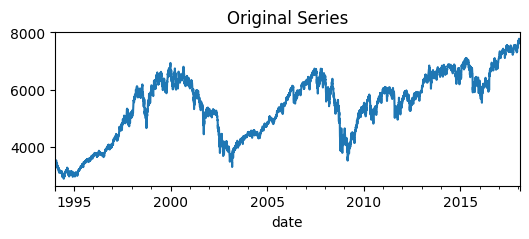

In [23]:
# Function to apply ADF test after each step
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f"\n--- {title} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("✅ Likely stationary (reject null)")
    else:
        print("❌ Likely non-stationary (fail to reject null)")

# Before applying any transformations, we can check the stationarity of the original series.
df_comp['market_value'].plot(figsize=(6,2), title="Original Series")
adf_test(df_comp['market_value'], "Original Series")

### 1. Removing Trend
- #### First-Order Differencing
    Removes linear trends by subtracting the previous value:
    - Δyₜ = yₜ – yₜ₋₁


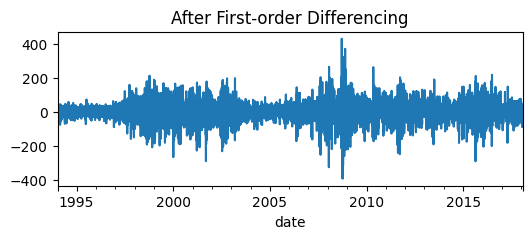


--- After First-order Differencing ---
ADF Statistic: -35.6236
p-value: 0.0000
✅ Likely stationary (reject null)


In [24]:
diff1 = df_comp['market_value'].diff()
diff1.plot(figsize=(6,2), title="After First-order Differencing")
plt.show()
adf_test(diff1, "After First-order Differencing")

The series became stationary after first-order differencing. \
Some series wont become stationary after first-order differencing, in such cases apply second-order differencing and run the test again.

- #### Linear Detrending or Detrending Using Regression
    Fit a trend line (e.g., linear or polynomial), then subtract it \
    **Y(t)' = Y(t)- ŷ(t) where ŷ(t) = a + bt**

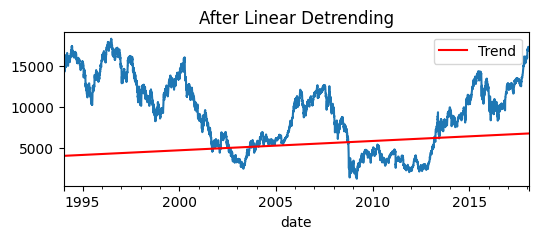


--- After Detrending ---
ADF Statistic: -1.5316
p-value: 0.5178
❌ Likely non-stationary (fail to reject null)


In [25]:
# Fit linear trend
t = np.arange(len(df_comp['market_value']))
coef = np.polyfit(t, df_comp['market_value'].values, 1)
trend = pd.Series(coef[0] * t + coef[1], index=df_comp['market_value'].index)

# Subtract trend
detrended = series - trend
detrended.plot(figsize=(6,2), title="After Linear Detrending")
trend.plot(label='Trend', color='red')
plt.legend()
plt.show()
adf_test(detrended, "After Detrending")

Linear detrending did'nt make the series stationary

### Removing Seasonality
- #### Seasonal Differencing
    Subtracts the value from the same period in the previous cycle \
    **Y(t)' = Y(t) - Y(t-s)** , Where s is the seasonal period (e.g., 12 for monthly data with yearly seasonality)

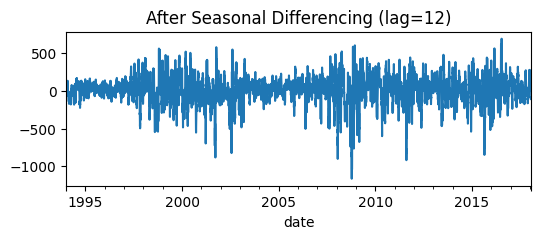


--- After Seasonal Differencing (lag=12) ---
ADF Statistic: -14.0815
p-value: 0.0000
✅ Likely stationary (reject null)


In [26]:
diff_seasonal = df_comp['market_value'].diff(12)
diff_seasonal.plot(figsize=(6,2), title="After Seasonal Differencing (lag=12)")
plt.show()
adf_test(diff_seasonal, "After Seasonal Differencing (lag=12)")

The series became stationary after seasonal differencing

### 3. Transformation (to stabilize variance)
- #### Log transformation
    Compresses the range and reduces growing variance \
    **Y(t)' = log(Y(t))**


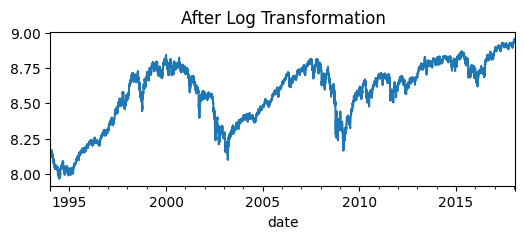


--- After Log Transformation ---
ADF Statistic: -1.7442
p-value: 0.4085
❌ Likely non-stationary (fail to reject null)


In [27]:
log_series = np.log(df_comp['market_value'])
log_series.plot(figsize=(6,2), title="After Log Transformation")
plt.show()  
adf_test(log_series, "After Log Transformation")

- #### Power/Square root transformation
    Useful when variance grows linearly with the mean \
    **Y(t)' = √Y(t)**

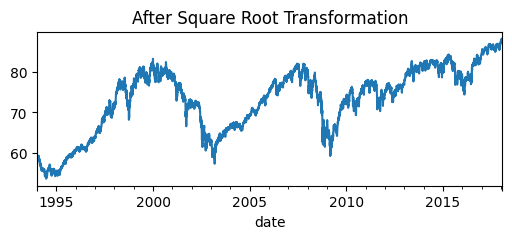


--- After Square Root Transformation ---
ADF Statistic: -1.5828
p-value: 0.4922
❌ Likely non-stationary (fail to reject null)


In [28]:
power_transformed = np.sqrt(df_comp['market_value'])
power_transformed.plot(figsize=(6,2), title="After Square Root Transformation")
plt.show()      
adf_test(power_transformed, "After Square Root Transformation")

- #### Box-Cox transformation
    Flexible transformation that includes log/sqrt as special cases. \
    Use it when the rolling standard deviation increases/decreases over time or the plot shows variance instability. \
    **y(λ) = { (y^λ - 1) / λ , if λ ≠ 0** \
    **y(λ) = { log(y), if λ = 0**

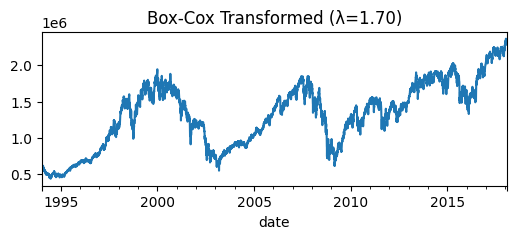


--- Box-Cox Transformed (λ=1.70) ---
ADF Statistic: -1.4902
p-value: 0.5383
❌ Likely non-stationary (fail to reject null)


In [29]:
from scipy.stats import boxcox

boxcox_transformed, lambda_bc = boxcox(df_comp['market_value'])
boxcox_series = pd.Series(boxcox_transformed, index=df_comp.index)
boxcox_series.plot(figsize=(6,2), title=f"Box-Cox Transformed (λ={lambda_bc:.2f})")
plt.show()
adf_test(boxcox_series, f"Box-Cox Transformed (λ={lambda_bc:.2f})")

None of the transformation techniques were successfull in removing stationarity of the series.

### 4. Decomposition 
- #### Residual Analysis (removing both trend & seasonality)
    Use decomposition techniques like STL or Classical Additive/Multiplicative Decomposition to Break the series into: \
    **Observed = Trend + Seasonal + Residual** \
    Use the residual component, which is expected to be stationary

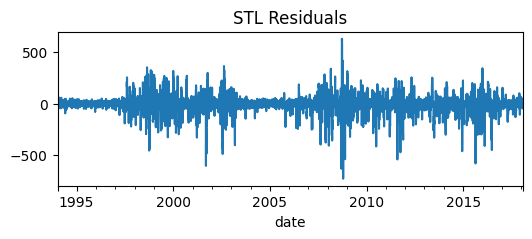


--- STL Residuals ---
ADF Statistic: -17.0740
p-value: 0.0000
✅ Likely stationary (reject null)


In [30]:
stl = STL(df_comp['market_value'], period=12, robust=True)
resid = stl.fit().resid
resid.plot(figsize=(6,2), title="STL Residuals")
plt.show()
adf_test(resid, "STL Residuals")

The residuals after removing the trend and the seasonality is stationary.

- #### Seasonal Adjustment
    Removing seasonal component using STL decomposition \
    Use **trend + residual** component for the analysis

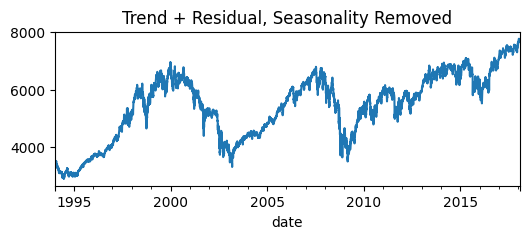


--- Trend + Residual, Seasonality Removed ---
ADF Statistic: -1.3926
p-value: 0.5858
❌ Likely non-stationary (fail to reject null)


In [31]:
stl = STL(df_comp['market_value'], period=12, robust=True)
stl_result  = stl.fit()
trend_plus_resid = stl_result .trend + stl_result .resid
trend_plus_resid.plot(figsize=(6,2), title="Trend + Residual, Seasonality Removed")
plt.show()
adf_test(trend_plus_resid, "Trend + Residual, Seasonality Removed")

Removing the seasonal component failed to make the series stationary because the series has trend which is accounting for non-stationarity.

#### ACF Plot

In [32]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(df.market_value, zero=False, lags=40)
plt.title('ACF: Prices', size=20)
plt.tight_layout() 
plt.show()

AttributeError: 'DataFrame' object has no attribute 'market_value'

#### Interpretation of the ACF plot
- Bars extending above the blue confidence band ⇒ Statistically significant autocorrelations.
- Lag 1 is near +1 and staying high: Today's price is very similar to yesterday’s, and even values 20–30 lags back still influence today’s price.
- The autocorrelations remain very strong and positive for all 40 lags—well outside the confidence bounds. That’s a clear indication of Non-stationarity in the time series.


